## **PROJETO FINAL 01: Fine-Tuning de uma CNN para Classificação**

## **CESAR SCHOOL**
* Pós-graduação em Engenharia e Análise de Dados - 2023.2
* **Disciplina: Tópicos Complementares**
* Professor: **Silvan Ferreira**
* Aluno: **Allan Bispo** - apsb@cesar.school

###**Apresentação do Dataset**
####**Caltech 256 Image Dataset**
* Considerado uma melhoria do Caltech 101, tem novos recursos como tamanhos de categoria maiores, novas e maiores categorias de desordem e dificuldade geral aumentada.
* Para esse projeto foram escolhidas as categorias 'gorilla' e 'horse' com, respectivamente, 212 e 270 imagens cada.
* A relação de treino e validação foi de 75% x 25%.
* https://www.kaggle.com/datasets/jessicali9530/caltech256

#### **Importando as bibliotecas e métodos necessários**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import zipfile

###**Construção do Dataset**
1. Verificação de disponibilidade de GPU;
2. Endereçamento dos arquivos fonte;
3. Download e descompactação dos arquivos;
4. Configurando os cenários de **data augmentation**;
5. Carregamento do dataset;
6. Apresentação de imagens de exemplo.

In [ ]:
# Verifica através do tensor CUDA se GPU está disponível no dispositivo, senão utiliza-se CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Endereçamento dos arquivos fonte

# URL do arquivo
url = "https://drive.google.com/uc?id=1XefsP462NYXig1-Li2a5fXYvV_L5gWBG"

# Nome do arquivo zip com as imagens de treino e validação
file_name = "caltech-256.zip"

# Caminho da pasta de destino
destination = "/content/data"

In [ ]:
#Download e descompactação dos arquivos

# Baixando o arquivo
response = requests.get(url, stream=True)
with open(file_name, 'wb') as out_file:
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        out_file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

# Descompactando o arquivo
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(destination)

print("Arquivo baixado e descompactado com sucesso!")

100%|██████████| 13.3M/13.3M [00:00<00:00, 25.2MiB/s]


Arquivo baixado e descompactado com sucesso!


----------------------------------------------------------------
###**Data Augmentation**
Técnica usada para **aumentar a
diversidade** de um dataset de treino, melhorando a generalização do modelo e **prevenindo overfitting**.
* Cenário **SEM data augmentation**: susceptível a overfitting
  * `transforms.Resize(230)`: Redimensiona todas as imagens para 230 pixels;
  * `transforms.CenterCrop(224)`: Corta uma região central de 224x224 pixels da imagem redimensionada;
  * t`ransforms.ToTensor()`: Converte a imagem em um tensor PyTorch;
  * `transforms.Normalize()`: Normaliza os valores dos pixels para uma faixa específica (neste caso, entre -0.5 e 0.5).
* Cenário **COM data augmentation**: utiliza data augmentation básica, melhorando a generalização do modelo.
  * `transforms.RandomResizedCrop(224)`: Corta uma região aleatória de 224x224 pixels da imagem, redimensionando-a se necessário;
  * `transforms.RandomHorizontalFlip()`: Inverte a imagem horizontalmente com uma probabilidade de 50%.

In [ ]:
# Configurando os cenários de data augmentation

# Cenário SEM data augmentation
transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cenário COM data augmentation
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Carregamento do dataset

data_dir = "data/caltech-256"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug) # treino SEM augmentation
train_set_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug) # treino COM augmentation
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug) # validação

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
# Apresentação de imagens de exemplo

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='none')
    if title is not None:
        plt.title(title)
    plt.show()

# Função para mostrar exemplos
def show_examples(loader, title):
    images, labels = next(iter(loader))
    images = images[:8]
    labels = labels[:8]
    imshow(torchvision.utils.make_grid(images, nrow=4), title)

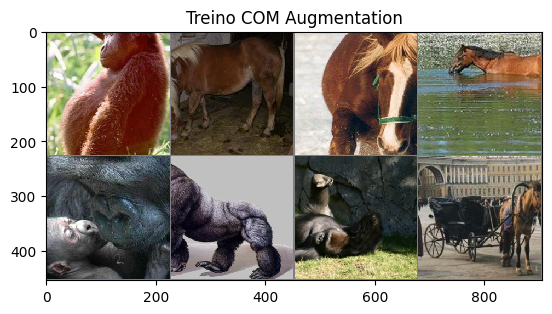

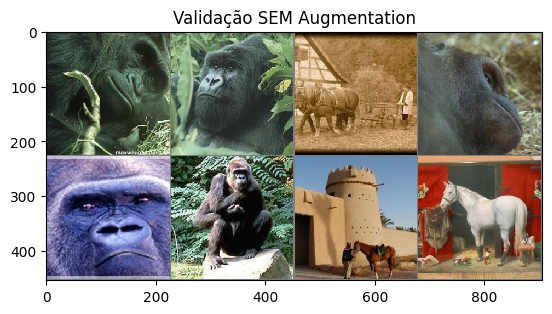

In [ ]:
# Mostrando exemplos de treino com data augmentation
show_examples(train_loader_aug, title="Treino COM Augmentation")
show_examples(val_loader, title="Validação SEM Augmentation")

--------------------------------------------------------------------------
###**Funções de Treino, Validação e Testes**
Definição das funções para:
* Treinar o modelo CNN de classificação
* Plotar o histórico de treinamento e validação
* Avaliar o modelo em um conjunto de testes

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

-------------------------------------------------------------------------
### **Construção do Modelo Classificador**

O **modelo CNN foi projetado para classificar imagens em duas classes**. Ele é composto por quatro blocos principais:

* `Camada Convolucional 1`: Extrai características básicas das imagens usando 4 filtros.
* `Camada Convolucional 2`: Extrai características mais complexas usando 8 filtros.
* `Camadas Fully Connected`: Reduz as características para 64 neurônios, mapeando os neurônios para as 2 classes de saída.
* `Forward`: Aplica convoluções, pooling, ReLU e camadas totalmente conectadas para gerar logits de classe.

Modelo equilibrado para simplificar complexidade e manter bom desempenho em classificação.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, stride=2, padding=0)
        self.fc1 = nn.Linear(8 * 13 * 13, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 8 * 13 * 13)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN(num_classes=2).to(device)

In [ ]:
# Define a função de perda e o otimizador para treinar um modelo de classificação

criterion = nn.CrossEntropyLoss() # Mede o erro do modelo em suas previsões
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Ajusta os parâmetros do modelo para minimizar esse erro

---------------------------------------------------------------------------
###**Treinamento e Curvas de Desempenho**
A seguir são apresentados os resultados de treinamento e validação com as curvas de desempenho nos diferentes cenários:
* Cenário **SEM data augmentation**:
  * `total overfitting`, erro e acurácia desconectados por completo dos dados de validação;
  * `modelo não conseguiu generalizar adequadamente sem data augmentation`, ficando inútil para aplicação prática.

In [ ]:
# Treinando a rede neural convolucional SEM Data Augmentation

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25)

100%|██████████| 11/11 [00:03<00:00,  3.24it/s]


Epoch 1, Train Loss: 0.689, Train Accuracy: 53.27%
Epoch 1, Val Loss: 0.674, Val Accuracy: 62.33%


100%|██████████| 11/11 [00:02<00:00,  5.11it/s]


Epoch 2, Train Loss: 0.675, Train Accuracy: 56.25%
Epoch 2, Val Loss: 0.651, Val Accuracy: 75.34%


100%|██████████| 11/11 [00:02<00:00,  5.21it/s]


Epoch 3, Train Loss: 0.605, Train Accuracy: 72.62%
Epoch 3, Val Loss: 0.602, Val Accuracy: 67.12%


100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


Epoch 4, Train Loss: 0.521, Train Accuracy: 75.00%
Epoch 4, Val Loss: 0.507, Val Accuracy: 76.03%


100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


Epoch 5, Train Loss: 0.462, Train Accuracy: 77.68%
Epoch 5, Val Loss: 0.432, Val Accuracy: 81.51%


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


Epoch 6, Train Loss: 0.405, Train Accuracy: 82.44%
Epoch 6, Val Loss: 0.473, Val Accuracy: 79.45%


100%|██████████| 11/11 [00:03<00:00,  3.62it/s]


Epoch 7, Train Loss: 0.325, Train Accuracy: 84.82%
Epoch 7, Val Loss: 0.454, Val Accuracy: 80.82%


100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


Epoch 8, Train Loss: 0.304, Train Accuracy: 85.12%
Epoch 8, Val Loss: 0.632, Val Accuracy: 71.92%


100%|██████████| 11/11 [00:02<00:00,  3.91it/s]


Epoch 9, Train Loss: 0.254, Train Accuracy: 88.10%
Epoch 9, Val Loss: 0.491, Val Accuracy: 76.03%


100%|██████████| 11/11 [00:02<00:00,  4.32it/s]


Epoch 10, Train Loss: 0.215, Train Accuracy: 90.18%
Epoch 10, Val Loss: 0.731, Val Accuracy: 73.97%


100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


Epoch 11, Train Loss: 0.188, Train Accuracy: 90.48%
Epoch 11, Val Loss: 0.721, Val Accuracy: 75.34%


100%|██████████| 11/11 [00:02<00:00,  3.76it/s]


Epoch 12, Train Loss: 0.140, Train Accuracy: 94.64%
Epoch 12, Val Loss: 0.778, Val Accuracy: 78.08%


100%|██████████| 11/11 [00:02<00:00,  5.17it/s]


Epoch 13, Train Loss: 0.209, Train Accuracy: 88.99%
Epoch 13, Val Loss: 0.621, Val Accuracy: 76.71%


100%|██████████| 11/11 [00:02<00:00,  5.16it/s]


Epoch 14, Train Loss: 0.136, Train Accuracy: 96.13%
Epoch 14, Val Loss: 0.748, Val Accuracy: 75.34%


100%|██████████| 11/11 [00:02<00:00,  5.01it/s]


Epoch 15, Train Loss: 0.206, Train Accuracy: 93.15%
Epoch 15, Val Loss: 1.193, Val Accuracy: 76.71%


100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


Epoch 16, Train Loss: 0.180, Train Accuracy: 91.07%
Epoch 16, Val Loss: 0.757, Val Accuracy: 80.14%


100%|██████████| 11/11 [00:02<00:00,  5.13it/s]


Epoch 17, Train Loss: 0.114, Train Accuracy: 95.83%
Epoch 17, Val Loss: 0.703, Val Accuracy: 74.66%


100%|██████████| 11/11 [00:02<00:00,  5.12it/s]


Epoch 18, Train Loss: 0.082, Train Accuracy: 97.32%
Epoch 18, Val Loss: 0.794, Val Accuracy: 79.45%


100%|██████████| 11/11 [00:02<00:00,  5.07it/s]


Epoch 19, Train Loss: 0.045, Train Accuracy: 98.81%
Epoch 19, Val Loss: 1.056, Val Accuracy: 76.03%


100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


Epoch 20, Train Loss: 0.061, Train Accuracy: 98.21%
Epoch 20, Val Loss: 1.150, Val Accuracy: 78.77%


100%|██████████| 11/11 [00:02<00:00,  5.07it/s]


Epoch 21, Train Loss: 0.079, Train Accuracy: 97.92%
Epoch 21, Val Loss: 0.880, Val Accuracy: 78.08%


100%|██████████| 11/11 [00:02<00:00,  5.18it/s]


Epoch 22, Train Loss: 0.163, Train Accuracy: 94.64%
Epoch 22, Val Loss: 0.814, Val Accuracy: 76.71%


100%|██████████| 11/11 [00:02<00:00,  3.68it/s]


Epoch 23, Train Loss: 0.191, Train Accuracy: 93.45%
Epoch 23, Val Loss: 0.751, Val Accuracy: 80.82%


100%|██████████| 11/11 [00:02<00:00,  3.86it/s]


Epoch 24, Train Loss: 0.146, Train Accuracy: 94.94%
Epoch 24, Val Loss: 0.590, Val Accuracy: 77.40%


100%|██████████| 11/11 [00:02<00:00,  5.08it/s]


Epoch 25, Train Loss: 0.095, Train Accuracy: 97.92%
Epoch 25, Val Loss: 0.982, Val Accuracy: 75.34%
Treinamento concluído


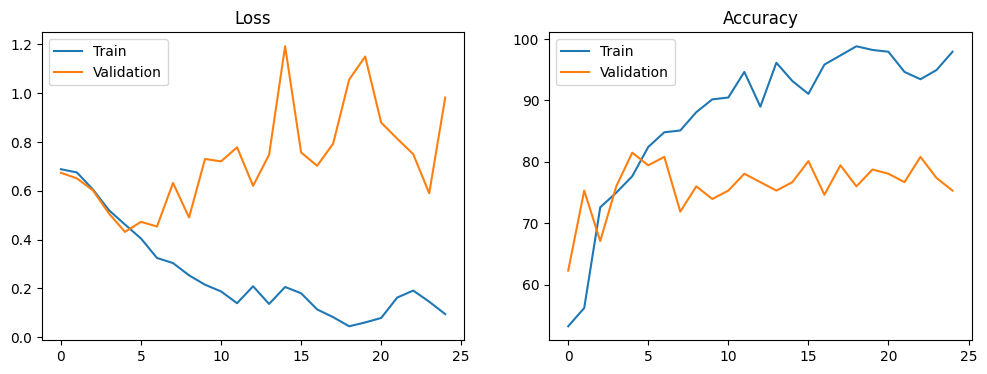

In [ ]:
plot_history(history) # SEM data augmentation

* Cenário **COM data augmentation**:
  * `Melhora clara no desempenho do modelo`, conseguindo generalizar nos dados de validação;
  * Os ajustes de redimensionamento e rotação aplicados às imagens de treinamento permitiram `resultados de validação aceitáveis`.

In [ ]:
# Treinando a rede neural convolucional COM Data Augmentation

history_aug = train_model(model, train_loader_aug, val_loader, criterion, optimizer, device, num_epochs=25)

100%|██████████| 11/11 [00:01<00:00,  5.51it/s]


Epoch 1, Train Loss: 0.676, Train Accuracy: 75.60%
Epoch 1, Val Loss: 0.497, Val Accuracy: 76.71%


100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


Epoch 2, Train Loss: 0.587, Train Accuracy: 70.24%
Epoch 2, Val Loss: 0.494, Val Accuracy: 81.51%


100%|██████████| 11/11 [00:02<00:00,  4.27it/s]


Epoch 3, Train Loss: 0.504, Train Accuracy: 76.19%
Epoch 3, Val Loss: 0.465, Val Accuracy: 76.71%


100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


Epoch 4, Train Loss: 0.471, Train Accuracy: 79.76%
Epoch 4, Val Loss: 0.426, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:02<00:00,  5.48it/s]


Epoch 5, Train Loss: 0.465, Train Accuracy: 78.27%
Epoch 5, Val Loss: 0.437, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:01<00:00,  5.58it/s]


Epoch 6, Train Loss: 0.515, Train Accuracy: 76.49%
Epoch 6, Val Loss: 0.401, Val Accuracy: 81.51%


100%|██████████| 11/11 [00:02<00:00,  3.85it/s]


Epoch 7, Train Loss: 0.431, Train Accuracy: 78.57%
Epoch 7, Val Loss: 0.364, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


Epoch 8, Train Loss: 0.480, Train Accuracy: 80.06%
Epoch 8, Val Loss: 0.330, Val Accuracy: 88.36%


100%|██████████| 11/11 [00:01<00:00,  5.64it/s]


Epoch 9, Train Loss: 0.478, Train Accuracy: 78.27%
Epoch 9, Val Loss: 0.469, Val Accuracy: 77.40%


100%|██████████| 11/11 [00:01<00:00,  5.66it/s]


Epoch 10, Train Loss: 0.477, Train Accuracy: 77.98%
Epoch 10, Val Loss: 0.308, Val Accuracy: 87.67%


100%|██████████| 11/11 [00:02<00:00,  4.44it/s]


Epoch 11, Train Loss: 0.387, Train Accuracy: 83.04%
Epoch 11, Val Loss: 0.348, Val Accuracy: 82.88%


100%|██████████| 11/11 [00:01<00:00,  5.52it/s]


Epoch 12, Train Loss: 0.421, Train Accuracy: 81.85%
Epoch 12, Val Loss: 0.327, Val Accuracy: 84.25%


100%|██████████| 11/11 [00:01<00:00,  5.60it/s]


Epoch 13, Train Loss: 0.405, Train Accuracy: 81.55%
Epoch 13, Val Loss: 0.344, Val Accuracy: 82.19%


100%|██████████| 11/11 [00:02<00:00,  5.47it/s]


Epoch 14, Train Loss: 0.368, Train Accuracy: 86.90%
Epoch 14, Val Loss: 0.325, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:02<00:00,  5.06it/s]


Epoch 15, Train Loss: 0.405, Train Accuracy: 82.44%
Epoch 15, Val Loss: 0.365, Val Accuracy: 84.25%


100%|██████████| 11/11 [00:02<00:00,  4.79it/s]


Epoch 16, Train Loss: 0.440, Train Accuracy: 80.95%
Epoch 16, Val Loss: 0.388, Val Accuracy: 82.88%


100%|██████████| 11/11 [00:01<00:00,  5.57it/s]


Epoch 17, Train Loss: 0.384, Train Accuracy: 83.93%
Epoch 17, Val Loss: 0.310, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


Epoch 18, Train Loss: 0.387, Train Accuracy: 86.61%
Epoch 18, Val Loss: 0.338, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:01<00:00,  5.52it/s]


Epoch 19, Train Loss: 0.391, Train Accuracy: 84.52%
Epoch 19, Val Loss: 0.346, Val Accuracy: 82.19%


100%|██████████| 11/11 [00:02<00:00,  4.14it/s]


Epoch 20, Train Loss: 0.382, Train Accuracy: 83.63%
Epoch 20, Val Loss: 0.348, Val Accuracy: 82.88%


100%|██████████| 11/11 [00:01<00:00,  5.64it/s]


Epoch 21, Train Loss: 0.401, Train Accuracy: 80.95%
Epoch 21, Val Loss: 0.361, Val Accuracy: 83.56%


100%|██████████| 11/11 [00:01<00:00,  5.54it/s]


Epoch 22, Train Loss: 0.388, Train Accuracy: 86.61%
Epoch 22, Val Loss: 0.322, Val Accuracy: 83.56%


100%|██████████| 11/11 [00:01<00:00,  5.64it/s]


Epoch 23, Train Loss: 0.370, Train Accuracy: 85.71%
Epoch 23, Val Loss: 0.315, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:02<00:00,  4.26it/s]


Epoch 24, Train Loss: 0.382, Train Accuracy: 83.93%
Epoch 24, Val Loss: 0.339, Val Accuracy: 86.99%


100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


Epoch 25, Train Loss: 0.303, Train Accuracy: 88.99%
Epoch 25, Val Loss: 0.318, Val Accuracy: 87.67%
Treinamento concluído


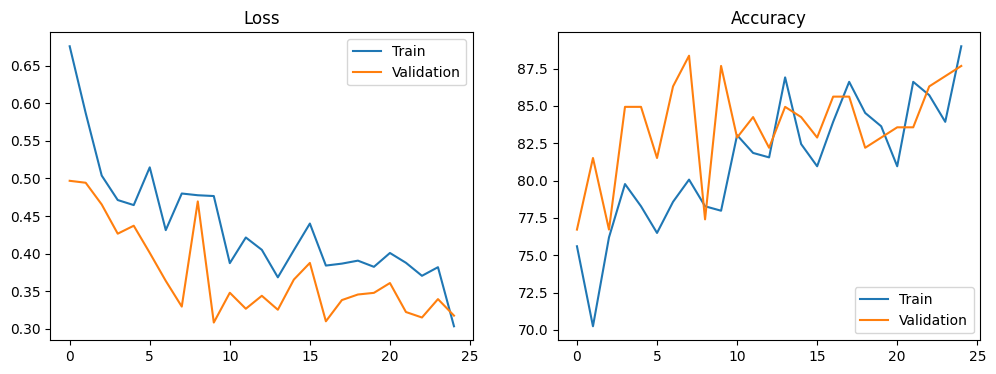

In [ ]:
plot_history(history_aug) # COM data augmentation

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 0.00%


####**PARCIAL:**
* Aplicando ao modelo dados aumentados resultou em melhor desempenho, com dados de validação apresentando erros menores e boa acurácia.
* Entretanto ainda há um pouco de overfitting, principalmente para as épocas maiores, sendo então útil ajustar os parâmetros via fine tuning.

-----------------------------------------------------------------------------
###**Fine Tuning Aplicado ao Data Augementation e ao Modelo CNN**

####**Data Augmentation com Fine Tuning**
* Cenário **adicionando transformações ao data augmentation - fine tuning**: utiliza data augmentation mais avançada, aumentando ainda mais a robustez do modelo.
  * `transforms.ColorJitter()`: Aplica variações aleatórias de brilho, contraste, saturação e matiz à imagem;
  * `transforms.RandomRotation()`: Rotaciona a imagem aleatoriamente em um ângulo entre -20 e 20 graus;
  * `transforms.RandomErasing()`: Apaga uma região aleatória da imagem com uma probabilidade de 50%.

In [ ]:
# Cenário de fine tuning aplicado ao Data Augmentation

transform_aug_ft = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

In [ ]:
# Carregamento do dataset com fine tuning

train_set_aug_ft = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug_ft) # treino com fine tuning

train_loader_aug_ft = DataLoader(train_set_aug_ft, batch_size=32, shuffle=True)

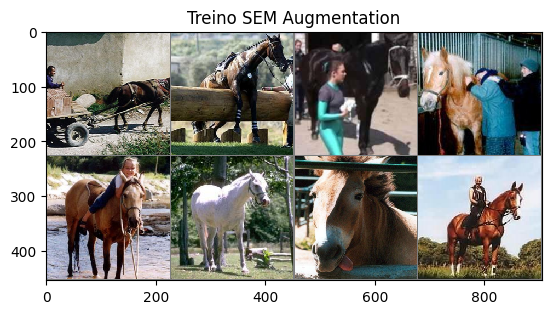

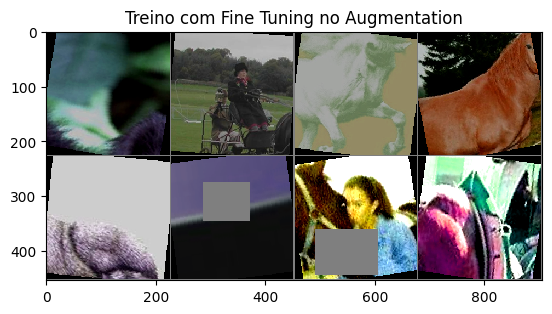

In [ ]:
# Mostrando exemplos de treino com data augmentation e fine tuning

show_examples(train_loader, title="Treino SEM Augmentation")
show_examples(train_loader_aug_ft, title="Treino com Fine Tuning no Augmentation")

####**Aplicando Fine Tuning ao modelo CNN**
O **modelo CNN foi ajustado para classificar imagens em duas classes de forma mais otimizada:**

* `Camada Convolucional 1`: Extrai características iniciais das imagens usando 8 filtros.
* `Camada Convolucional 2`: Aprofunda a extração com 16 filtros adicionais.
* `Camadas Fully Connected`: Três camadas densas reduzem progressivamente as dimensões, de 2704 para 256, depois 64, até chegar nas 2 saídas.
* `Funções de Ativação e Pooling`: ReLU e Max Pooling adicionam não linearidade e reduzem a dimensionalidade.

O modelo é eficaz pois se utiliza de convoluções e pooling para extrair e processar características visuais.

In [ ]:
class CNN_ft(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 13 * 13, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 16 * 13 * 13)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = CNN_ft(num_classes=2).to(device)

* Aplicou-se um `learning rate de 0.001` ao otimizador para melhorar a estabilidade dos resultados.

In [ ]:
# Define a função de perda e o otimizador para treinar um modelo de classificação

criterion = nn.CrossEntropyLoss() # Mede o erro do modelo em suas previsões
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # Ajusta os parâmetros do modelo para minimizar esse erro

In [ ]:
# Treinando a rede neural convolucional com Fine Tuning no Data Augmentation e no modelo

history_aug_ft = train_model(model_ft, train_loader_aug_ft, val_loader, criterion, optimizer_ft, device, num_epochs=25)

100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


Epoch 1, Train Loss: 0.506, Train Accuracy: 77.38%
Epoch 1, Val Loss: 0.326, Val Accuracy: 84.25%


100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


Epoch 2, Train Loss: 0.492, Train Accuracy: 73.81%
Epoch 2, Val Loss: 0.327, Val Accuracy: 86.99%


100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


Epoch 3, Train Loss: 0.496, Train Accuracy: 78.27%
Epoch 3, Val Loss: 0.338, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Epoch 4, Train Loss: 0.494, Train Accuracy: 77.08%
Epoch 4, Val Loss: 0.332, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epoch 5, Train Loss: 0.470, Train Accuracy: 77.08%
Epoch 5, Val Loss: 0.350, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Epoch 6, Train Loss: 0.497, Train Accuracy: 74.11%
Epoch 6, Val Loss: 0.333, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


Epoch 7, Train Loss: 0.468, Train Accuracy: 78.27%
Epoch 7, Val Loss: 0.331, Val Accuracy: 86.99%


100%|██████████| 11/11 [00:04<00:00,  2.29it/s]


Epoch 8, Train Loss: 0.479, Train Accuracy: 77.38%
Epoch 8, Val Loss: 0.345, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


Epoch 9, Train Loss: 0.479, Train Accuracy: 75.60%
Epoch 9, Val Loss: 0.335, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epoch 10, Train Loss: 0.469, Train Accuracy: 78.57%
Epoch 10, Val Loss: 0.361, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Epoch 11, Train Loss: 0.447, Train Accuracy: 78.57%
Epoch 11, Val Loss: 0.339, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


Epoch 12, Train Loss: 0.488, Train Accuracy: 77.38%
Epoch 12, Val Loss: 0.342, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Epoch 13, Train Loss: 0.459, Train Accuracy: 82.44%
Epoch 13, Val Loss: 0.340, Val Accuracy: 84.25%


100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


Epoch 14, Train Loss: 0.459, Train Accuracy: 78.27%
Epoch 14, Val Loss: 0.338, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Epoch 15, Train Loss: 0.451, Train Accuracy: 80.65%
Epoch 15, Val Loss: 0.330, Val Accuracy: 84.25%


100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


Epoch 16, Train Loss: 0.497, Train Accuracy: 77.98%
Epoch 16, Val Loss: 0.346, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


Epoch 17, Train Loss: 0.449, Train Accuracy: 78.57%
Epoch 17, Val Loss: 0.363, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


Epoch 18, Train Loss: 0.456, Train Accuracy: 76.49%
Epoch 18, Val Loss: 0.356, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


Epoch 19, Train Loss: 0.513, Train Accuracy: 77.08%
Epoch 19, Val Loss: 0.340, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.460, Train Accuracy: 77.68%
Epoch 20, Val Loss: 0.342, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


Epoch 21, Train Loss: 0.446, Train Accuracy: 80.65%
Epoch 21, Val Loss: 0.348, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:04<00:00,  2.36it/s]


Epoch 22, Train Loss: 0.454, Train Accuracy: 78.27%
Epoch 22, Val Loss: 0.339, Val Accuracy: 83.56%


100%|██████████| 11/11 [00:04<00:00,  2.39it/s]


Epoch 23, Train Loss: 0.463, Train Accuracy: 76.79%
Epoch 23, Val Loss: 0.329, Val Accuracy: 85.62%


100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


Epoch 24, Train Loss: 0.465, Train Accuracy: 79.17%
Epoch 24, Val Loss: 0.333, Val Accuracy: 86.30%


100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


Epoch 25, Train Loss: 0.439, Train Accuracy: 78.57%
Epoch 25, Val Loss: 0.346, Val Accuracy: 86.99%
Treinamento concluído


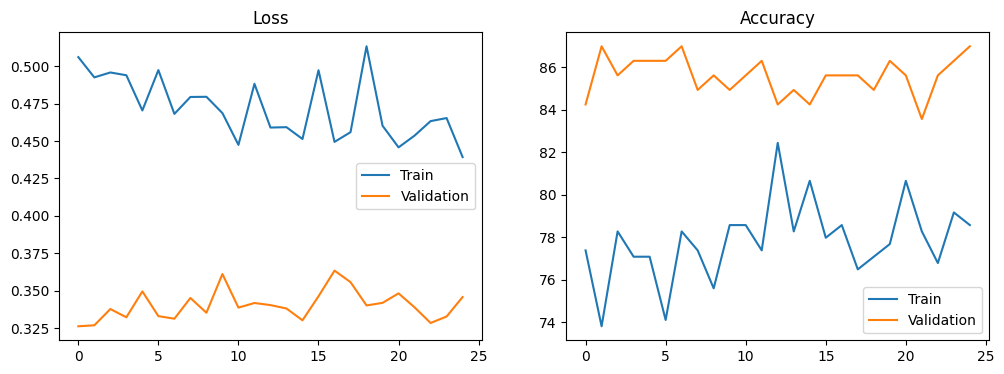

In [ ]:
plot_history(history_aug_ft) # Com Fine Tuning no Data Augmentation e no modelo CNN

In [ ]:
test_model(model_ft, val_loader)

Acurácia da rede na base de teste: 86.99%


####**CONCLUSÃO CNN:**
* Após o processo de `fine tuning aplicados ao data augmentation, ao modelo CNN e ao otimizador`, o resultado foi melhorado.
  * Os ajustes nos parâmetros de `colorjitter`, juntamente com `rotações e deleções aleatórias` aplicadas às imagens via data augmentation melhoraram a robustez do modelo.
  * O modelo teve ajuste por `aumento de camadas e layer fc, além de inclusão de camadas de ativação ReLU`.
  * O otimizador teve o `learning rate ampliado` para estabilizar mais os dados.
  ---------------------------------------------------------------------------

###**Uso de Modelos Pré-treinados**
Nesta etapa vamos `comparar o dempenho` do modelo CNN aqui apresentado contra os modelos pré-treinados: `AlexNet, VGG16 e ResNet18`.
* OBSERVAÇÃO: para fins de otimização de tempo o número de `epochs foi reduzido para 10`.

####**Modelo AlexNet**
* Modelo pioneiro em redes neurais convolucionais profundas, ideal para datasets menores e tarefas básicas de classificação.

In [ ]:
#Testando com o modelo AlexNet

model_alex = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

In [ ]:
# Rodando a cross entropy e o otimizador agora com o modelo AlexNet

criterion = nn.CrossEntropyLoss()
optimizer_alex = optim.SGD(model_alex.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN agora com o modelo AlexNet

history_alex = train_model(model_alex, train_loader_aug_ft, val_loader, criterion, optimizer_alex, device, num_epochs=10)

100%|██████████| 11/11 [00:39<00:00,  3.62s/it]


Epoch 1, Train Loss: 3.829, Train Accuracy: 40.48%
Epoch 1, Val Loss: 1.644, Val Accuracy: 63.70%


100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Epoch 2, Train Loss: 1.579, Train Accuracy: 54.46%
Epoch 2, Val Loss: 0.587, Val Accuracy: 69.86%


100%|██████████| 11/11 [00:41<00:00,  3.74s/it]


Epoch 3, Train Loss: 0.677, Train Accuracy: 66.67%
Epoch 3, Val Loss: 0.498, Val Accuracy: 75.34%


100%|██████████| 11/11 [00:41<00:00,  3.75s/it]


Epoch 4, Train Loss: 0.675, Train Accuracy: 65.77%
Epoch 4, Val Loss: 0.435, Val Accuracy: 81.51%


100%|██████████| 11/11 [00:38<00:00,  3.48s/it]


Epoch 5, Train Loss: 0.575, Train Accuracy: 71.73%
Epoch 5, Val Loss: 0.416, Val Accuracy: 76.03%


100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


Epoch 6, Train Loss: 0.543, Train Accuracy: 72.02%
Epoch 6, Val Loss: 0.334, Val Accuracy: 84.25%


100%|██████████| 11/11 [00:37<00:00,  3.37s/it]


Epoch 7, Train Loss: 0.495, Train Accuracy: 77.98%
Epoch 7, Val Loss: 0.330, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:37<00:00,  3.39s/it]


Epoch 8, Train Loss: 0.421, Train Accuracy: 80.06%
Epoch 8, Val Loss: 0.297, Val Accuracy: 86.99%


100%|██████████| 11/11 [00:38<00:00,  3.54s/it]


Epoch 9, Train Loss: 0.417, Train Accuracy: 79.76%
Epoch 9, Val Loss: 0.383, Val Accuracy: 84.93%


100%|██████████| 11/11 [00:36<00:00,  3.36s/it]


Epoch 10, Train Loss: 0.452, Train Accuracy: 79.76%
Epoch 10, Val Loss: 0.290, Val Accuracy: 85.62%
Treinamento concluído


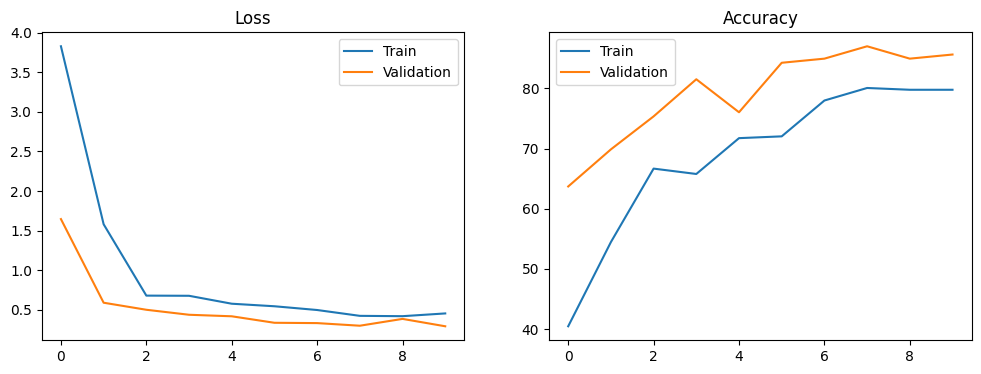

In [ ]:
# Visualizando as perdas e acurácia agora com o modelo AlexNet

plot_history(history_alex)

In [ ]:
test_model(model_alex, val_loader)

Acurácia da rede na base de teste: 85.62%


####**Modelo VGG16**
* Modelo de arquitetura clássica e intuitiva, com bom desempenho em diversas tarefas, especialmente em datasets de tamanho médio.

In [ ]:
# Alterando para VGG16

model_vgg16 = models.vgg16(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.4MB/s]


In [ ]:
# Rodando a cross entropy e o otimizador agora com o modelo VGG16

criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN agora com o modelo VGG16

history_vgg16 = train_model(model_vgg16, train_loader_aug_ft, val_loader, criterion, optimizer_vgg16, device, num_epochs=10)

100%|██████████| 11/11 [12:52<00:00, 70.22s/it]


Epoch 1, Train Loss: 3.452, Train Accuracy: 38.10%
Epoch 1, Val Loss: 0.539, Val Accuracy: 76.03%


 18%|█▊        | 2/11 [03:43<16:47, 111.90s/it]


KeyboardInterrupt: 

In [ ]:
# Visualizando as perdas e acurácia agora com o modelo VGG16

plot_history(history_vgg16)

In [ ]:
test_model(model_vgg16, val_loader)

####**Modelo ResNet18**
* Modelo de arquitetura balanceada e eficiente, ideal para datasets de tamanho médio e tarefas de classificação gerais.

In [ ]:
# Alterando para ResNet18

model_rn18 = models.resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.4MB/s]


In [ ]:
# Rodando a cross entropy e o otimizador agora com o modelo ResNet18

criterion = nn.CrossEntropyLoss()
optimizer_rn18 = optim.SGD(model_rn18.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN agora com o modelo ResNet18

history_rn18 = train_model(model_rn18, train_loader_aug_ft, val_loader, criterion, optimizer_rn18, device, num_epochs=10)

100%|██████████| 11/11 [01:34<00:00,  8.62s/it]


Epoch 1, Train Loss: 0.084, Train Accuracy: 95.83%
Epoch 1, Val Loss: 0.078, Val Accuracy: 95.89%


100%|██████████| 11/11 [01:32<00:00,  8.42s/it]


Epoch 2, Train Loss: 0.116, Train Accuracy: 94.94%
Epoch 2, Val Loss: 0.060, Val Accuracy: 97.26%


100%|██████████| 11/11 [01:31<00:00,  8.35s/it]


Epoch 3, Train Loss: 0.084, Train Accuracy: 97.62%
Epoch 3, Val Loss: 0.063, Val Accuracy: 97.26%


100%|██████████| 11/11 [01:31<00:00,  8.30s/it]


Epoch 4, Train Loss: 0.090, Train Accuracy: 96.43%
Epoch 4, Val Loss: 0.071, Val Accuracy: 97.26%


100%|██████████| 11/11 [01:31<00:00,  8.28s/it]


Epoch 5, Train Loss: 0.078, Train Accuracy: 97.02%
Epoch 5, Val Loss: 0.113, Val Accuracy: 97.26%


100%|██████████| 11/11 [01:31<00:00,  8.36s/it]


Epoch 6, Train Loss: 0.095, Train Accuracy: 96.73%
Epoch 6, Val Loss: 0.074, Val Accuracy: 97.26%


100%|██████████| 11/11 [01:31<00:00,  8.30s/it]


Epoch 7, Train Loss: 0.095, Train Accuracy: 97.02%
Epoch 7, Val Loss: 0.069, Val Accuracy: 97.26%


100%|██████████| 11/11 [01:31<00:00,  8.36s/it]


Epoch 8, Train Loss: 0.119, Train Accuracy: 96.73%
Epoch 8, Val Loss: 0.061, Val Accuracy: 97.26%


100%|██████████| 11/11 [01:32<00:00,  8.42s/it]


Epoch 9, Train Loss: 0.061, Train Accuracy: 97.92%
Epoch 9, Val Loss: 0.058, Val Accuracy: 96.58%


100%|██████████| 11/11 [01:31<00:00,  8.34s/it]


Epoch 10, Train Loss: 0.060, Train Accuracy: 97.62%
Epoch 10, Val Loss: 0.055, Val Accuracy: 96.58%
Treinamento concluído


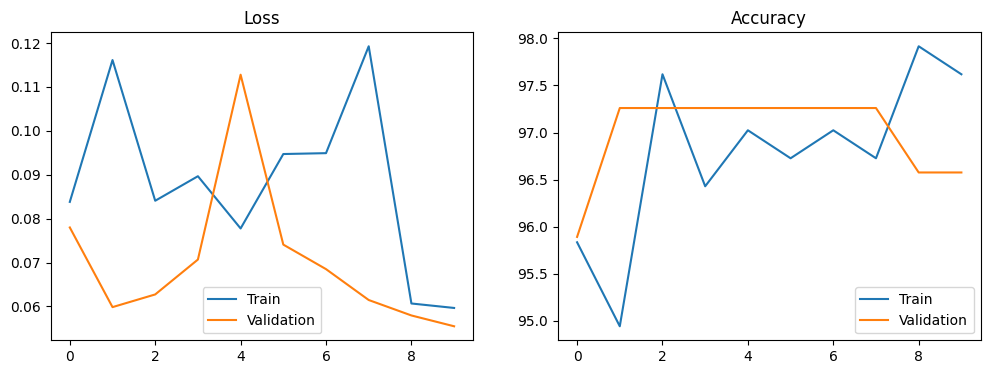

In [ ]:
# Visualizando as perdas e acurácia agora com o modelo ResNet18

plot_history(history_rn18)

In [ ]:
test_model(model_rn18, val_loader)

Acurácia da rede na base de teste: 96.58%


####**CONCLUSÃO MODELOS PRÉ-TREINADOS**:

* Apesar do **modelo VGG16** apresentar uma melhor performance, o **tempo** gasto no processamento, em especial com device cpu, foi **muito grande para um acréscimo de acurácia pequeno**. Para um dataset simples não se justificaria o uso do VGG16.
* O **modelo AlexNet** foi o **mais rápido** de todos, mas devido a sua arquitetura mais simples, **teve uma acurácia inferior**.
* Dos três modelos testados aqui, o **melhor custo-benefício foi o do ResNet18**.
* Abaixo pode-se comparar a evolução do processo de fine tunning:
  * **Modelo Resnet18: Acurácia** da rede na base de teste: **96.58%**
  * **Modelo AlexNet: Acurácia** da rede na base de teste: **85.62%**
  * **Modelo VGG16: Acurácia** da rede na base de teste: **xxxxx**
----------------------------------------------------------------------------

###**Congelamento de Camadas**
* O congelamento de camadas é uma das etapas da técnica de *`Transfer Learning`*.
* Transfer Learning:
    * `Técnica` que aproveita um modelo pré-treinado em um grande dataset para ser reutilizado em uma tarefa similar com menos dados;
    * `Etapas`:
      * Modelo Pré-treinado: Treine um modelo grande em um dataset grande
      * Congelamento de Camadas: Congele as camadas iniciais do modelo
     * Fine-tuning: Adapte e treine as camadas finais com dados do novo problema
específico.
* `Para esse estudo será usado o modelo ResNet18` por apresentar um bom custo-benefício entre desempenho e tempo de processamento.


In [ ]:
# Alterando para ResNet18

model_rn18_cc = models.resnet18(weights="IMAGENET1K_V1")

In [ ]:
# Mostras os módulos do modelo

for name, module in model_rn18_cc.named_modules():
    print(f"Module Name: {name}")
    print(module)
    print("="*50)

Module Name: 
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [ ]:
# Congelar todas as camadas

for param in model_rn18_cc.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada

model_rn18_cc.fc = nn.Linear(model_rn18_cc.fc.in_features, 2)
model_rn18_cc = model_rn18_cc.to(device)

In [ ]:
# Rodando a cross entropy e o otimizador agora com o modelo ResNet18 com congelamento de camadas

criterion = nn.CrossEntropyLoss()
optimizer_rn18_cc = optim.SGD(model_rn18_cc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a ResNet18 com camadas congeladas

history_rn18_cc = train_model(model_rn18_cc, train_loader_aug_ft, val_loader, criterion, optimizer_rn18_cc, device, num_epochs=10)

100%|██████████| 11/11 [00:40<00:00,  3.66s/it]


Epoch 1, Train Loss: 0.669, Train Accuracy: 58.33%
Epoch 1, Val Loss: 0.415, Val Accuracy: 91.10%


100%|██████████| 11/11 [00:35<00:00,  3.24s/it]


Epoch 2, Train Loss: 0.485, Train Accuracy: 77.98%
Epoch 2, Val Loss: 0.188, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:34<00:00,  3.14s/it]


Epoch 3, Train Loss: 0.359, Train Accuracy: 87.20%
Epoch 3, Val Loss: 0.174, Val Accuracy: 96.58%


100%|██████████| 11/11 [00:35<00:00,  3.19s/it]


Epoch 4, Train Loss: 0.342, Train Accuracy: 86.90%
Epoch 4, Val Loss: 0.093, Val Accuracy: 97.95%


100%|██████████| 11/11 [00:35<00:00,  3.24s/it]


Epoch 5, Train Loss: 0.271, Train Accuracy: 90.77%
Epoch 5, Val Loss: 0.095, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:35<00:00,  3.23s/it]


Epoch 6, Train Loss: 0.277, Train Accuracy: 91.37%
Epoch 6, Val Loss: 0.081, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:35<00:00,  3.19s/it]


Epoch 7, Train Loss: 0.237, Train Accuracy: 91.37%
Epoch 7, Val Loss: 0.082, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:34<00:00,  3.17s/it]


Epoch 8, Train Loss: 0.250, Train Accuracy: 89.58%
Epoch 8, Val Loss: 0.073, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:35<00:00,  3.19s/it]


Epoch 9, Train Loss: 0.199, Train Accuracy: 93.15%
Epoch 9, Val Loss: 0.076, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:34<00:00,  3.17s/it]


Epoch 10, Train Loss: 0.224, Train Accuracy: 93.45%
Epoch 10, Val Loss: 0.071, Val Accuracy: 97.26%
Treinamento concluído


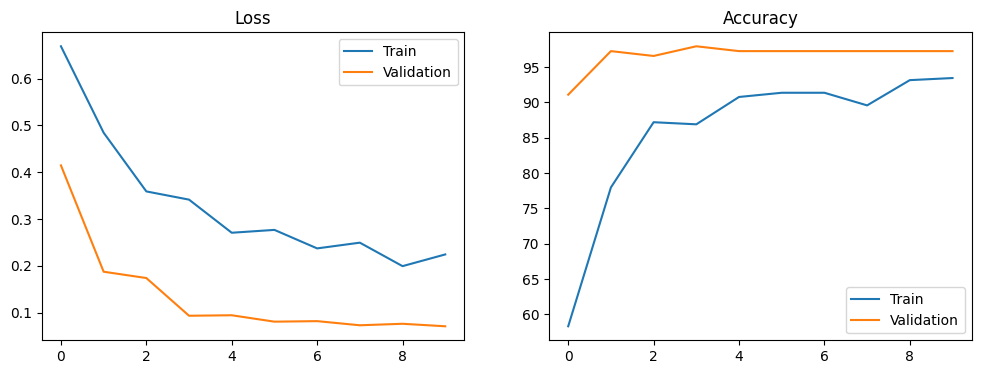

In [ ]:
plot_history(history_rn18_cc)

In [ ]:
test_model(model_rn18_cc, val_loader)

Acurácia da rede na base de teste: 97.26%


####**PARCIAL**:

* Aplicando `congelamento na última camada (fc)` resultou em `melhoria da performance`, indo a acurácia de 96.58% para 97.26%.
* Pode-se praticar o fine `tuning descongelamento de mais camadas`.

#####**Descongelando a camada layer4[1]**

In [ ]:
# Congelar todas as camadas

for param in model_rn18_cc.parameters():
    param.requires_grad = False

In [ ]:
# Substituindo as camadas layer4.1 e fc

# Descongelar a layer4[1]
for param in model_rn18_cc.layer4[1].parameters():
    param.requires_grad = True

model_rn18_cc.fc = nn.Linear(model_rn18_cc.fc.in_features, 2)
model_rn18_cc_l4 = model_rn18_cc.to(device)

In [ ]:
# Rodando a cross entropy e o otimizador agora com as 2 camadas substituídas

criterion = nn.CrossEntropyLoss()
optimizer_rn18_cc_l4 = optim.SGD(model_rn18_cc_l4.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN novamente

history_rn18_cc_l4 = train_model(model_rn18_cc_l4, train_loader_aug_ft, val_loader, criterion, optimizer_rn18_cc_l4, device, num_epochs=10)

100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


Epoch 1, Train Loss: 0.606, Train Accuracy: 61.61%
Epoch 1, Val Loss: 0.298, Val Accuracy: 93.84%


100%|██████████| 11/11 [00:40<00:00,  3.72s/it]


Epoch 2, Train Loss: 0.450, Train Accuracy: 81.85%
Epoch 2, Val Loss: 0.111, Val Accuracy: 97.95%


100%|██████████| 11/11 [00:41<00:00,  3.74s/it]


Epoch 3, Train Loss: 0.264, Train Accuracy: 90.77%
Epoch 3, Val Loss: 0.085, Val Accuracy: 97.95%


100%|██████████| 11/11 [00:42<00:00,  3.90s/it]


Epoch 4, Train Loss: 0.238, Train Accuracy: 90.77%
Epoch 4, Val Loss: 0.083, Val Accuracy: 97.95%


100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


Epoch 5, Train Loss: 0.213, Train Accuracy: 92.56%
Epoch 5, Val Loss: 0.055, Val Accuracy: 97.95%


100%|██████████| 11/11 [00:40<00:00,  3.68s/it]


Epoch 6, Train Loss: 0.198, Train Accuracy: 91.37%
Epoch 6, Val Loss: 0.071, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:40<00:00,  3.69s/it]


Epoch 7, Train Loss: 0.190, Train Accuracy: 92.86%
Epoch 7, Val Loss: 0.043, Val Accuracy: 97.95%


100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


Epoch 8, Train Loss: 0.189, Train Accuracy: 92.56%
Epoch 8, Val Loss: 0.061, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:43<00:00,  3.96s/it]


Epoch 9, Train Loss: 0.186, Train Accuracy: 92.86%
Epoch 9, Val Loss: 0.063, Val Accuracy: 97.26%


100%|██████████| 11/11 [00:40<00:00,  3.71s/it]


Epoch 10, Train Loss: 0.185, Train Accuracy: 94.35%
Epoch 10, Val Loss: 0.050, Val Accuracy: 97.95%
Treinamento concluído


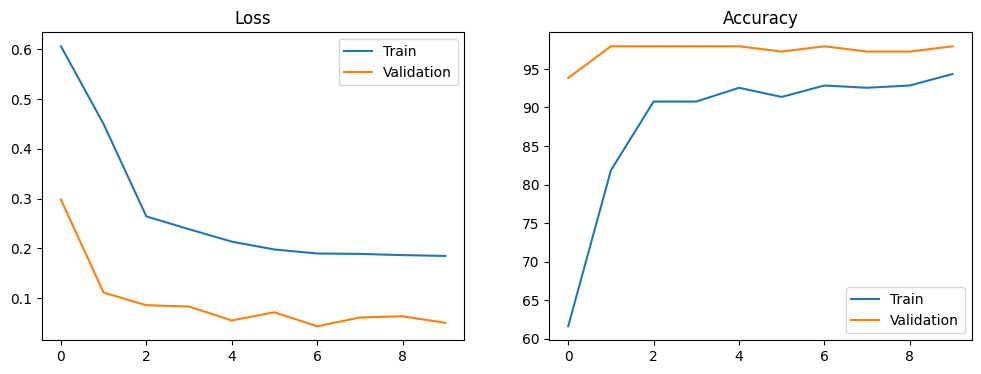

In [ ]:
# Visualizando as perdas e acurácia com as novas camadas

plot_history(history_rn18_cc_l4)

In [ ]:
# Testando o modelo na nova configuração de camadas

test_model(model_rn18_cc, val_loader)

Acurácia da rede na base de teste: 97.95%


####**CONCLUSÃO CONGELAMENTO DE CAMADAS**:

* À medida que as **camadas finais** do modelo ResNet18 vão sendo **descongeladas**, juntamente com a fully connected, o **modelo torna-se mais calibrado**, resultando em melhores acurácia, o que é bem característico do **fine tunning**.
* Abaixo pode-se comparar a evolução do processo de fine tunning:
  * **Descongelamento apenas fc: Acurácia** da rede na base de teste: **97.26%**
  * **Descongelamento layer4[1] + fc: Acurácia** da rede na base de teste: **97.95%**